In [1]:
import rasterio
import numpy as np
from rasterio import windows
from itertools import product

In [2]:
def get_windows(src, overlap, width, height, boundless=True):
    offsets = product(range(0, src.meta['width'], width), range(0, src.meta['height'], height))
    full_window = windows.Window(col_off=0, row_off=0, width=src.meta['width'], height=src.meta['height'])
    for col_off, row_off in offsets:
        window = windows.Window(
            col_off=col_off - overlap,
            row_off=row_off - overlap,
            width=width,
            height=height)
        
        if boundless:
            yield window
        else:
            yield window.intersection(full_window)


In [3]:
width = 20
height = 20
overlap = 5

# Window loading from the single image

In [4]:
%%time
source_data = "../../data/TestDataSet/S2_comp_first.tif"

with rasterio.open(source_data) as src:
    window_list = [w for w in get_windows(src, overlap, width, height)]

CPU times: user 1.39 s, sys: 42.8 ms, total: 1.43 s
Wall time: 1.46 s


In [5]:
%%time
import random
random.shuffle(window_list)
window_list

CPU times: user 158 ms, sys: 0 ns, total: 158 ms
Wall time: 156 ms


[Window(col_off=9555, row_off=2615, width=20, height=20),
 Window(col_off=7595, row_off=1935, width=20, height=20),
 Window(col_off=2935, row_off=3395, width=20, height=20),
 Window(col_off=6755, row_off=8735, width=20, height=20),
 Window(col_off=9915, row_off=6315, width=20, height=20),
 Window(col_off=3375, row_off=7855, width=20, height=20),
 Window(col_off=4415, row_off=8255, width=20, height=20),
 Window(col_off=5735, row_off=1335, width=20, height=20),
 Window(col_off=5275, row_off=4375, width=20, height=20),
 Window(col_off=5935, row_off=1775, width=20, height=20),
 Window(col_off=9315, row_off=5875, width=20, height=20),
 Window(col_off=8515, row_off=9635, width=20, height=20),
 Window(col_off=5315, row_off=1195, width=20, height=20),
 Window(col_off=3955, row_off=9475, width=20, height=20),
 Window(col_off=75, row_off=4355, width=20, height=20),
 Window(col_off=6995, row_off=4695, width=20, height=20),
 Window(col_off=3695, row_off=9455, width=20, height=20),
 Window(col_off=

In [6]:
%%time
with rasterio.open(source_data) as src:
    arrays = [src.read([1, 2, 3], window=window, boundless=False) for window in window_list]

CPU times: user 18.4 s, sys: 772 ms, total: 19.1 s
Wall time: 20.9 s


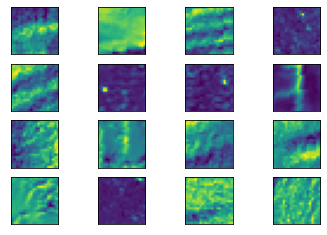

In [11]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(4,4)
count=0
for ax in axes.flat:
    ax.imshow(arrays[count].sum(axis=0))
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    count+=1

In [ ]:
%%time
import concurrent.futures

with rasterio.open(source_data) as src:
    def write_array(array, window, outpath):
        profile = src.profile
        profile.update(
            transform=src.window_transform(window),
            height=window.height,
            width=window.width)
        with rasterio.open(outpath, 'w', **profile) as dst:
            dst.write(array)
    
    with concurrent.futures.ThreadPoolExecutor(
            max_workers=8
        ) as executor:
            futures = executor.map(write_array, arrays, window_list, outpath_list)

# Window loading from multiple files

In [24]:
%%time
from pathlib import Path
source_data_dir = Path("../../data/TestDataSet/S2_comp_first_retile16/")

files = [e for e in source_data_dir.iterdir() if e.is_file()]
window_list=[]
for source_data in files:
    with rasterio.open(source_data) as src:
        window_list.extend([(source_data, w) for w in get_windows(src, overlap, width, height)])

CPU times: user 711 ms, sys: 10.3 ms, total: 722 ms
Wall time: 787 ms


In [25]:
%%time
import random
random.shuffle(window_list)
window_list

CPU times: user 125 ms, sys: 236 µs, total: 126 ms
Wall time: 124 ms


[(PosixPath('../../data/TestDataSet/S2_comp_first_retile16/tile_14.tif'),
  Window(col_off=2235, row_off=2235, width=20, height=20)),
 (PosixPath('../../data/TestDataSet/S2_comp_first_retile16/tile_3.tif'),
  Window(col_off=2295, row_off=1855, width=20, height=20)),
 (PosixPath('../../data/TestDataSet/S2_comp_first_retile16/tile_5.tif'),
  Window(col_off=2035, row_off=2115, width=20, height=20)),
 (PosixPath('../../data/TestDataSet/S2_comp_first_retile16/tile_4.tif'),
  Window(col_off=375, row_off=915, width=20, height=20)),
 (PosixPath('../../data/TestDataSet/S2_comp_first_retile16/tile_0.tif'),
  Window(col_off=2315, row_off=655, width=20, height=20)),
 (PosixPath('../../data/TestDataSet/S2_comp_first_retile16/tile_0.tif'),
  Window(col_off=1755, row_off=1275, width=20, height=20)),
 (PosixPath('../../data/TestDataSet/S2_comp_first_retile16/tile_4.tif'),
  Window(col_off=2575, row_off=2015, width=20, height=20)),
 (PosixPath('../../data/TestDataSet/S2_comp_first_retile16/tile_7.tif')

In [34]:
%%time
arrays=[]
for f, w in window_list[:int(len(window_list)/16)]: #1/16 of all data
    with rasterio.open(f) as src:
        arrays.extend(src.read([1, 2, 3], window=w, boundless=False))

CPU times: user 1min 51s, sys: 6.05 s, total: 1min 57s
Wall time: 3min 7s


In [62]:
%%time
import concurrent.futures

def load_window(f, w):
    with rasterio.open(f) as src:
        array = (src.read([1, 2, 3], window=w, boundless=False))
        return array

f, w = list(zip(*window_list[:int(len(window_list)/16)]))
with concurrent.futures.ThreadPoolExecutor(
        max_workers=8
    ) as executor:
        futures = executor.map(load_window, f, w)
arrays = [f for f in futures]

CPU times: user 1min 55s, sys: 9.62 s, total: 2min 5s
Wall time: 1min 9s


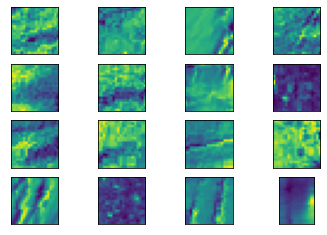

In [63]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(4,4)
count=0
for ax in axes.flat:
    ax.imshow(arrays[count].sum(axis=0))
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    count+=1